# MNIST

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

from torchvision import datasets, transforms, utils
from torch.autograd import Variable

In [2]:
def show_batch(batch):
    im = utils.make_grid(batch)
    plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

In [3]:
train_loader = torch.utils.data.DataLoader(datasets.MNIST('../mnist_data', 
                                                          download=True, 
                                                          train=True,
                                                          transform=transforms.Compose([
                                                              transforms.ToTensor(), # first, convert image to PyTorch tensor
                                                              transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
                                                          ])), 
                                           batch_size=10, shuffle=True)

In [4]:
test_loader = torch.utils.data.DataLoader(datasets.MNIST('../mnist_data', 
                                                          download=True, 
                                                          train=False,
                                                          transform=transforms.Compose([
                                                              transforms.ToTensor(), # first, convert image to PyTorch tensor
                                                              transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
                                                          ])), 
                                           batch_size=10, shuffle=True)

In [5]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.dropout(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)
    


In [6]:
clf = CNNClassifier()
opt = optim.SGD(clf.parameters(), lr=0.01, momentum=0.9)

In [7]:
train_size = 1000
test_size = 100

In [8]:
def train():
    clf.train()
    step_id = []
    test_losses = []
    test_accuracies = []
    train_losses = []
    train_accuracies = []
    
    for batch_id, (data, label) in enumerate(train_loader):
        if batch_id > train_size:
            break
            
        data = Variable(data)
        target = Variable(label)
        
        opt.zero_grad()
        preds = clf(data)
        loss = F.nll_loss(preds, target)
        loss.backward()
        opt.step()
        
        if batch_id % 100 == 0:
            step_id.append(batch_id)
            
            test_loss, test_acc = check(batch_id)
            test_losses.append(test_loss)
            test_accuracies.append(test_acc)
            
            train_loss, train_acc = check(batch_id, train=True)
            train_losses.append(train_loss)
            train_accuracies.append(train_acc)

    return step_id, test_losses, test_accuracies, train_losses, train_accuracies

def check(step_id, train=False):
    clf.eval() # set model in inference mode (need this because of dropout)
    loss = 0
    batch_id = 0
    correct = 0
    keyword = "test"
    loader = test_loader
    
    if train:
        loader = train_loader
        keyword = "train"
        
    for data, target in loader:
        if batch_id > test_size:
            break
        
        with torch.no_grad():
            data = Variable(data) 
            target = Variable(target)
        
        output = clf(data)
        correct += (torch.max(output.data, 1)[1] == target).sum()
        loss += F.nll_loss(output, target).item()
        batch_id += 1

    loss /= batch_id # loss function already averages over batch size
    acc = float(correct) / batch_id * loader.batch_size
    
    print("{0} step: {1} | loss: {2:.4f} | accuracy: {3:.4f}".format(
                keyword,
                step_id,
                loss,
                acc
            ))
    
    return loss, acc

In [9]:
steps, test_losses, test_accuracies, train_losses, train_accuracies = train()

test step: 0 | loss: 2.3156 | accuracy: 2.6733
train step: 0 | loss: 2.3125 | accuracy: 3.1683
test step: 100 | loss: 0.5973 | accuracy: 80.0990
train step: 100 | loss: 0.5346 | accuracy: 83.7624
test step: 200 | loss: 0.4255 | accuracy: 85.8416
train step: 200 | loss: 0.4913 | accuracy: 82.6733
test step: 300 | loss: 0.3554 | accuracy: 88.4158
train step: 300 | loss: 0.3324 | accuracy: 89.4059
test step: 400 | loss: 0.2737 | accuracy: 90.4950
train step: 400 | loss: 0.2891 | accuracy: 91.3861
test step: 500 | loss: 0.2359 | accuracy: 92.0792
train step: 500 | loss: 0.2491 | accuracy: 91.9802
test step: 600 | loss: 0.2778 | accuracy: 92.2772
train step: 600 | loss: 0.2523 | accuracy: 92.5743
test step: 700 | loss: 0.2092 | accuracy: 93.5644
train step: 700 | loss: 0.2833 | accuracy: 92.2772
test step: 800 | loss: 0.3277 | accuracy: 91.8812
train step: 800 | loss: 0.3238 | accuracy: 90.3960
test step: 900 | loss: 0.2016 | accuracy: 94.6535
train step: 900 | loss: 0.1831 | accuracy: 94.6

# Графики зависимости потерь и точности от шага обучения

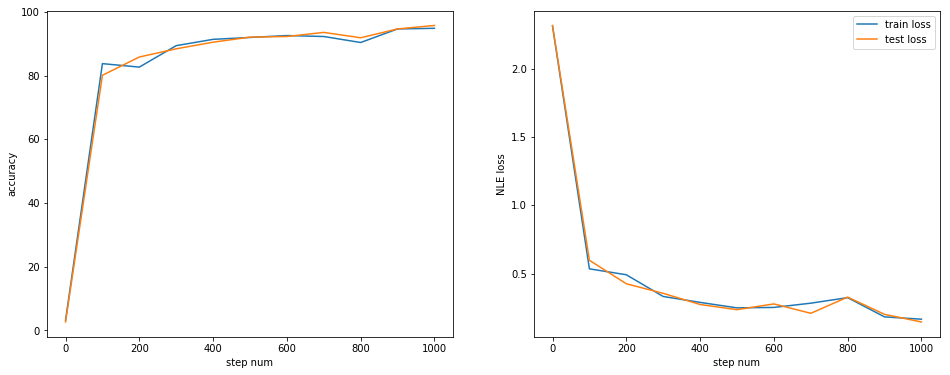

In [10]:
plt.figure(figsize=(16, 6))

ax1=plt.subplot(1, 2, 2)
ax1.plot(steps, train_losses, label="train loss")
ax1.plot(steps, test_losses, label="test loss")

plt.ylabel("NLE loss")
plt.xlabel("step num")
plt.legend()

ax2=plt.subplot(1, 2, 1)
ax2.plot(steps, train_accuracies, label="train")
ax2.plot(steps, test_accuracies, label="test")

plt.ylabel("accuracy")
plt.xlabel("step num")
plt.legend

plt.show()

# Наложение шума

In [11]:
def noised_data(disp):
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../mnist_data', 
            download=True, 
            train=True,
            transform=transforms.Compose([
                transforms.ToTensor(), # first, convert image to PyTorch tensor
                transforms.Normalize((0.1307,), (0.3081,)), # normalize inputs
                transforms.Lambda(lambda x: x + torch.Tensor(x.shape).normal_(0, disp))
            ])), 
        batch_size=10, shuffle=True
    )

    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../mnist_data', 
            download=True, 
            train=False,
            transform=transforms.Compose([
                transforms.ToTensor(), # first, convert image to PyTorch tensor
                transforms.Normalize((0.1307,), (0.3081,)), # normalize inputs
                transforms.Lambda(lambda x: x + torch.Tensor(x.shape).normal_(0, disp))
                ])), 
            batch_size=10, shuffle=True)
    
    return train_loader, test_loader

In [27]:
disps = [0.1, 0.2, 0.4, 0.8, 1, 10]

results = []
for (disp_id, disp) in enumerate(disps):
    train_loader, test_loader = noised_data(disp)
    clf = CNNClassifier()
    opt = optim.SGD(clf.parameters(), lr=0.01, momentum=0.9)

    results.append(train())

test step: 0 | loss: 2.3050 | accuracy: 7.8218
train step: 0 | loss: 2.3051 | accuracy: 7.2277
test step: 100 | loss: 0.7230 | accuracy: 79.2079
train step: 100 | loss: 0.7597 | accuracy: 78.8119
test step: 200 | loss: 0.3936 | accuracy: 88.2178
train step: 200 | loss: 0.4733 | accuracy: 85.9406
test step: 300 | loss: 0.2314 | accuracy: 92.2772
train step: 300 | loss: 0.2357 | accuracy: 92.9703
test step: 400 | loss: 0.2481 | accuracy: 93.3663
train step: 400 | loss: 0.2706 | accuracy: 91.7822
test step: 500 | loss: 0.1727 | accuracy: 95.5446
train step: 500 | loss: 0.1336 | accuracy: 95.5446
test step: 600 | loss: 0.1631 | accuracy: 94.6535
train step: 600 | loss: 0.1964 | accuracy: 93.4653
test step: 700 | loss: 0.1804 | accuracy: 94.0594
train step: 700 | loss: 0.2348 | accuracy: 92.1782
test step: 800 | loss: 0.1886 | accuracy: 94.0594
train step: 800 | loss: 0.2076 | accuracy: 93.8614
test step: 900 | loss: 0.1270 | accuracy: 96.1386
train step: 900 | loss: 0.1459 | accuracy: 95.5

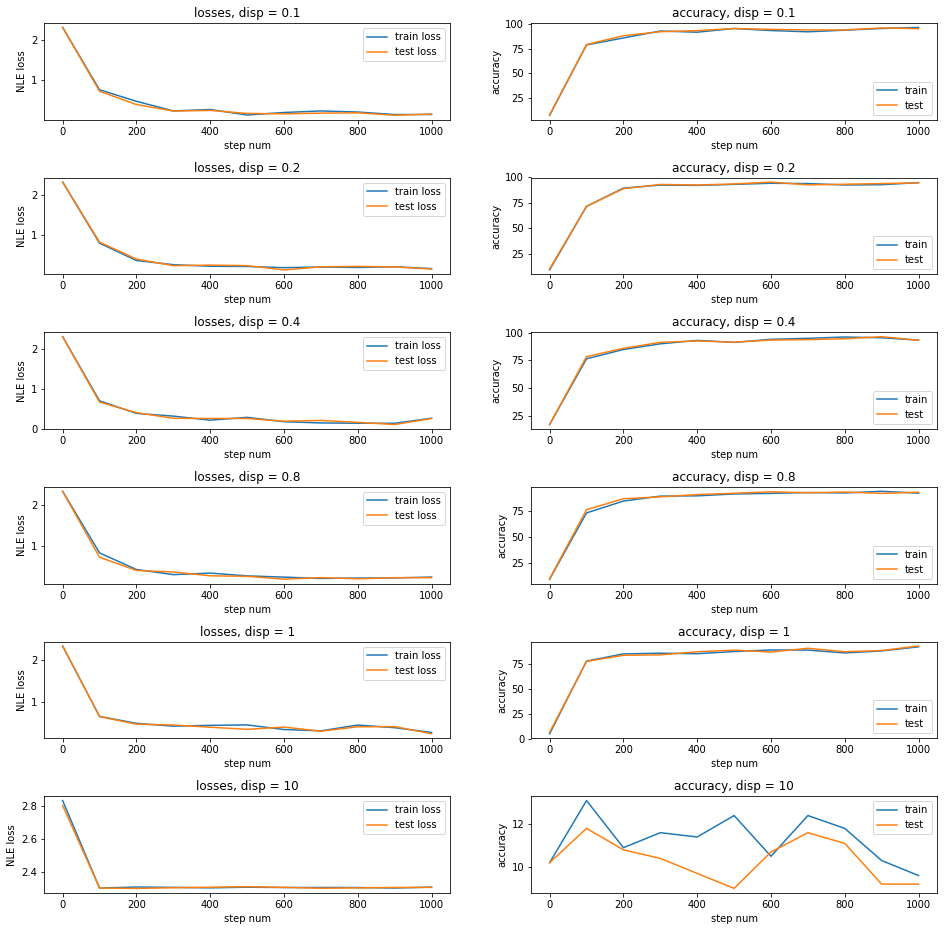

In [30]:
%matplotlib inline
plt.figure(figsize=(16, 16))

subplot_index = 0

for (disp_id, disp) in enumerate(disps):
    subplot_index += 1
    steps, test_losses, test_accuracies, train_losses, train_accuracies = results[disp_id]
    
    plt.subplot(len(disps), 2, subplot_index)
#     plt.plot(x, x ** disp_id)
    plt.plot(steps, train_losses, label="train loss")
    plt.plot(steps, test_losses, label="test loss")
    plt.title("losses, disp = {0}".format(disp))

    plt.ylabel("NLE loss")
    plt.xlabel("step num")
    plt.legend()
    
    subplot_index += 1

    plt.subplot(len(disps), 2, subplot_index)
    plt.plot(steps, train_accuracies, label="train")
    plt.plot(steps, test_accuracies, label="test")
    plt.title("accuracy, disp = {0}".format(disp))
    
    plt.ylabel("accuracy")
    plt.xlabel("step num")
    plt.legend()
    
    plt.subplots_adjust(hspace=0.6)